# Find years where LF ice is not coded

In [4]:
import numpy as np 
import cmocean
import cmocean.cm as cmo
import xarray as xr   
from pathlib import Path
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')

from functions import load_ice, trend, find_trends, plot_cartopy, decomp

# input data directory

path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Construct the full file name
fname = path / '{}.nc'.format(region)

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
# ds = xr.open_dataset(fname, decode_times=False)
# ds2021 = xr.open_dataset(fname2021, decode_times=False)

ds = xr.open_dataset(fname)

juld = ds.juld

# subset `xarray.Dataset` by index
ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))

# create shortcuts to the variables. 
lon = ds.longitude
lat = ds.latitude
land = ds.land
# E_FA = ds['E_FA']
E_CT = ds['E_CT']
E_SA = ds['E_SA']
E_FA = ds['E_FA']
N_CT = ds['N_CT'] # Concentration for LF ice in old charts used N_Ct not E_Ct

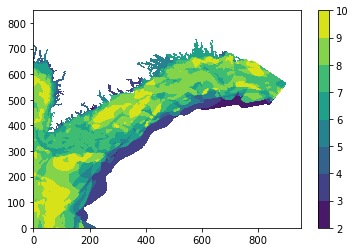

In [12]:
ds_yearly = E_CT.groupby("juld.year")

# Take averages
ds_yearly_means = ds_yearly.mean(dim=["juld"])
plt.contourf(ds_yearly_means[0,:,:])
plt.colorbar()

# Plot number of LF ice code occurences each year

In [4]:
LF_bool = np.empty((24, 12))
LF_bool[:] = np.nan

cnt2=0

for yr in list(ds_yearly):
    # Separate each year into month
    cnt1=0
    for mon in list(yr[1].groupby("juld.month")):
        print(yr[0], mon[0], (8 in mon[1]))
        LF_bool[cnt2, cnt1] = 8 in mon[1]
        cnt1+=1
    cnt2+=1

1997 1 False
1997 2 False
1997 3 False
1997 4 False
1997 5 True
1997 6 False
1997 7 False
1997 8 False
1997 9 False
1997 10 False
1997 11 False
1997 12 False
1998 1 False
1998 2 False
1998 3 False
1998 4 False
1998 5 False
1998 6 False
1998 7 False
1998 8 False
1998 9 False
1998 10 False
1998 11 False
1998 12 False
1999 1 True
1999 2 True
1999 3 False
1999 4 False
1999 5 False
1999 6 False
1999 7 False
1999 8 False
1999 9 False
1999 10 False
1999 11 False
1999 12 False
2000 1 False
2000 2 False
2000 3 False
2000 4 False
2000 5 False
2000 6 False
2000 7 False
2000 8 False
2000 9 False
2000 10 False
2000 11 False
2000 12 False
2001 1 False
2001 2 True
2001 3 True
2001 4 True
2001 5 True
2001 6 False
2001 7 False
2001 8 False
2001 9 False
2001 10 False
2001 11 False
2001 12 True
2002 1 True
2002 2 True
2002 3 True
2002 4 False
2002 5 False
2002 6 True
2002 7 False
2002 8 False
2002 9 False
2002 10 False
2002 11 False
2002 12 False
2003 1 False
2003 2 True
2003 3 False
2003 4 False
2003 5 

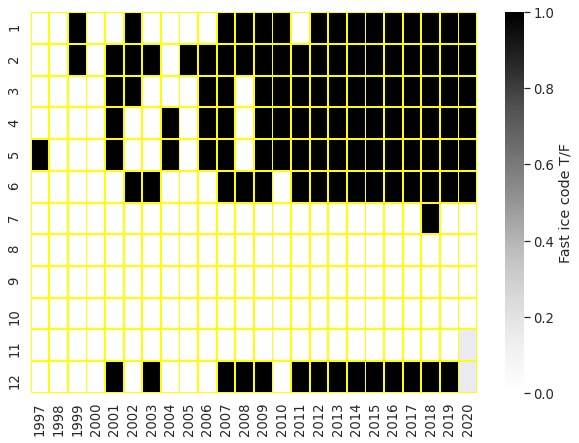

In [13]:
import seaborn as sns
sns.set(font_scale=1.2)

plt.figure(figsize=(10,7),facecolor='white')
ax = sns.heatmap(LF_bool.transpose(), cmap='Greys', cbar_kws={'label': 'Fast ice code T/F'}, linewidths=1, linecolor='yellow')
# plt.imshow(LF_bool.transpose(), cmap='Greys',  interpolation='nearest')
ax.set_xticklabels(np.arange(1997,2021),rotation='vertical')
ax.set_yticklabels(np.arange(1,13))
plt.savefig('/home/mwang/CIS/figures/Jun16_LFbool.png')

In [10]:
def plot_cartopy(ax, lon, lat):
    '''
    Set up the cartopy map with projection rotated so that Labrador coast is vertical. Input is the ax handle. 
    '''
    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='black',
    facecolor=('silver'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='dimgrey')

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
    #     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
    # domain = [55, -61.30979545701268, 59, -61]

    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
    # Rotation for vertical coast
    rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

#     # Plot results
#     transform = rot.transform_points(rot,lon,lat)
#     x_n = transform[...,0]
#     y_n = transform[...,1]

    ax.add_feature(LAND_highres,zorder=3)
    ax.add_feature(OCEAN_highres,zorder=2)
    ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
    ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
    

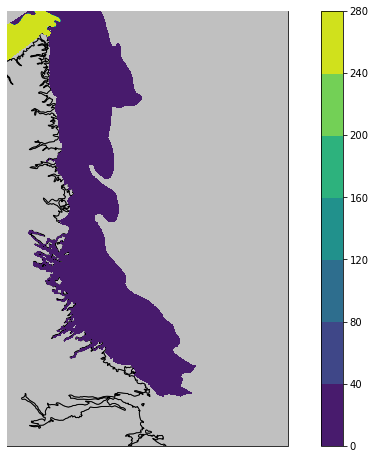

In [11]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
plt.contourf(lon,lat,E_FA.sel(juld='1997-5-15').where(E_FA.sel(juld='1999-2-1')<10), transform=ccrs.PlateCarree(), zorder=4)
plt.colorbar()